title: Prelude to Imputation: Understanding Missingness
date: 2019-11-22 11:35
Category: Machine Learning
Tags: Machine Learning, Deep Learning
author: Haw-minn Lu

## Nomenclature for Missingness

To better understand the issue of imputation of missing data, it is important to understand the concept of missingness. There are many reasons why data might be missing. For example, in survey data there are respondants to fail to submit responses to all categories. In health care, older records may be incomplete because recording standards have been updated to include more information. There are countless other reasons.

It is often confusing the nomenclature used by various authors relating to missing data. From the engineers point of view data is in a table comprising rows and columns. However, data scientists often refer to rows as records, covariates, exogenous variables,  or observations and columns as features, dependent variables, endogenous variables or attributes.

Often the literature has unclear and  confusing definitions of missingness. We will attempt to clarify and provide examples of various missingness models and patterns. Our first step is to make a distinction between *missingness mechanisms* and *missingness patterns*.
Missingness mechanisms refers to one of three situations that the literature agrees on: (1) missing completely at random (MCAR), (2) missing at random (MAR) and (3) missing not at random (MNAR). 

* **MCAR** -- A row of a table has a missing element (or even a missing row) with probability independent of the values of the features in that row.

* **MAR** -- Unlike MCAR, here the probability of a missing element or row **is** functionally dependent on the values of the features in that row that are **not** subject to missingness. An example might be in a survey where a family that accepts school free lunchs may be less likely to respond to the question of income. Thus, the data show that the family participates in the free lunch program but the income for that family is absent in the table. 

* **MNAR** -- For all cases other than MCAR and MAR. This implies that the missingness is a function of variables in both the features that are **not** subject to missingness  and those that which are subject to missingness. Thus, a feature could be eliminated  probabilistically based upon its own value, which means that it does not appear in the resulting table. For example, a respondent who was overweight might be less likely to report his/her body weight. Thus, the resulting table does not contain a value for body weight at all.

Missingness *patterns* is terminology less commonly used term in the literature. Recent publications refer to _uniform_ and _random_ and others refer to _uniform_, _monotonic_ and _non-monotonic_. For the purposes here, we'll focus on the former. A good description of latter can be found in Li's paper [On weighting approaches for missing data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3998729/). To best understand the difference in patterns attributes (i.e., table columns) should be split into those that are subject to missingness and those that are not. Thus, A *uniform* missingness pattern means that all attributes subject to missingness are missing where as *random* missingness pattern means a uniformly random selection of attributes subject to missingness are missing. 

In summary, the missingness *mechanism* decides *which* rows have missing attributes. The missingness *pattern* indicates which columns of the rows with potentially missing attributes are actually missing. These distinctions should become clearer with the following examples.

### The Dataset

The example dataset will be a 3-dimensional normal distribution with $x$, $y_1$, $y_2$.
The respective correlation coefficients are $\rho_{xy_1}, \rho_{xy_2}, \rho_{y_1y_2}$. Only the $x$ attribute is not subject to missingness. The covariance matrix is the following,  


$$\begin{bmatrix}1 & \rho_{xy_1} & \rho_{xy_2}\\ 
\rho_{xy_1} & 1 & \rho_{y_1y_2} \\
\rho_{xy_2} & \rho{y_1y_2} & 1\end{bmatrix}.$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.stats import bernoulli, multivariate_normal
%matplotlib inline

We will construct the data set based on the description shown above (with arbitrary values for the correlation coefficients)

In [2]:
rhoxy1  = .5
rhoy1y2 = .4
rhoxy2  = .6
cov = np.matrix([[1, rhoxy1, rhoxy2], [rhoxy1, 1, rhoy1y2],
                 [rhoxy2, rhoy1y2, 1]])
size = 10000  # simulation samples
mvrn = multivariate_normal(mean=[0, 0, 0], cov=cov)
dataset = pd.DataFrame(data=mvrn.rvs(size), columns=['x', 'y1', 'y2'])

The scatterplot below shows samples from the $y_1$ and $y_2$ dimensions.

Text(0, 0.5, '$y_2$')

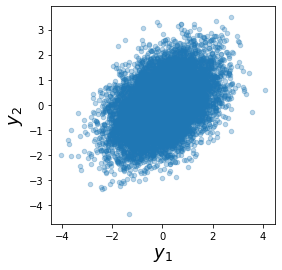

In [3]:
fig, ax = plt.subplots()
ax.set_aspect(1)
dataset.plot.scatter(x='y1', y='y2', alpha=.3, ax=ax)
ax.set_xlabel('$y_1$', fontsize=18)
ax.set_ylabel('$y_2$', fontsize=18)

## Implementation of the missingness model

The following function clobbers both $y_1$ and $y_2$ if the uniform missingness pattern is selected. If not selected (i.e., random missingness pattern), then either $y_1$, $y_2$ or both are clobbered with equal probability.

In [4]:
def corrupt_pattern(x, y1, y2, uniform=False):
    '''
    corrupt a given row of data [x, y1, y2] according to either uniform or random pattern
    :param x:  x variable
    :param y1: y1 variable
    :param y2: y2 variable
    :param uniform: if True corrupt uniformly (i.e., both y1 and y2)
    :return: row of x, y1, y2 with data corrupted
    '''
    if uniform:
        return x, np.nan, np.nan
    else:
        row = [(x, y1, np.nan), (x, np.nan, y2), (x, np.nan, np.nan)]
        return random.choice(row)

#### Implementation of missingness mechamisms

Our missingness is generated using a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution). The literature sometimes implements this by taking a random variable uniformly distributed ($v$) over $[0,1]$ using something like `numpy.random.uniform.` Then, they implement the missingness model based on whether $v<p_t$. This is just a construction of a Bernoulli distribution from a uniform distribution. In the case of our example, for clarity we use the random variates, `rvs()` method of the `scipy.stats.bernoulli` class. 

We designate $p_t$ as the _tuning probability_ for controlling the proportion of corrupted rows for our experiment. It does not reflect on the percentage of actually corrupted rows or missing attributes because that is controlled by the missingness mechanism. For example, $p_t=0.2$ used in the MCAR construction might result in 20% corrupted rows, but used in the MNAR construction might only result in 10% corrupted rows. The primary function of $p_t$ is to tweak the proportionate number of corrupted rows. 

In our specific implementation of some of the missingness mechanisms, it will be necessary to map a random value to a valid probability, i.e. we need to map $\mathbb R$ to $[0,1]$. To do this we use the sigmoid function 

$$\sigma(x) =  {1\over 1+e^{-x}}$$

This function is available  as `scipy.special.expit`.

In [5]:
from scipy.special import expit as sigmoid

#### Implementation of the MCAR mechanism

The MCAR missingness mechanism is straightforward. A Bernoulli random variate ($v$) trial is obtained for each row and if  $v=1$, then the missingness model is applied to that row. Otherwise, the row is left alone. Note that `scipy.stats.bernoulli.rvs(size)` produces a Numpy array of Bernoulli trials of length `size.` Hence we use `size=1` and dereference the array by using the `[0]` subscript. In our particular MCAR case the Bernoulli distribution parameter $p_b=p_t$.

In [6]:
def mcar_corrupt(x, y1, y2, uniform=False, pt=0.2):
    '''
    Implement an MCAR corruption mechanism on a row [x, y1, y2] of data
    :param x:  x variable
    :param y1: y1 variable
    :param y2: y2 variable
    :param uniform: if True corrupt uniformly (i.e., both y1 and y2)
    :param pt: tuning probability
    :return: row of x, y1, y2 with data corrupted
    '''

    if bernoulli(pt).rvs():
        return corrupt_pattern(x, y1, y2, uniform)
    return x, y1, y2

#### Implementation of the MAR mechanism

The MAR missingess mechanism uses a Bernoulli random variable with  parameter   $p_b=p_t\sigma(f(x))$ which makes the missingness a *function* of the attribute $x$, which is *always* observed in the data. Recall that the MAR mechanism is based on factors in our observed dataset. The following function applies this missingness mechanism:

In [7]:
def mar_corrupt(x, y1, y2, f, uniform=False, pt=0.2):
    '''
    Implement an MAR corruption mechanism on a row [x, y1, y2] of data
    :param x:  x variable
    :param y1: y1 variable
    :param y2: y2 variable
    :param f: a function of x used to determine the corruption
    :param uniform: if True corrupt uniformly (i.e., both y1 and y2)
    :param pt: tuning probability
    :return: row of x, y1, y2 with data corrupted
    '''
    brv = bernoulli(pt * sigmoid(f(x)))
    if brv.rvs():
        return corrupt_pattern(x, y1, y2, uniform)
    return x, y1, y2

#### Implementation of the MNAR mechanism

In The MNAR missingness mechanism also uses an alternate probability for a Bernoulli trial. In this case we have $p_b=p_t\sigma(f(y_1, y_2))$ which makes the missingness a probabilistic function of the attributes $y_1$ and $y_2$ which as a result of our construction may be absent from the observed data set. This is the MNAR mechanism because the missingness is based on unobserved elements in the resulting data.

In addition a second mechanism is provided by  `mnar_classic`. This second MNAR mechanism construction has been seen in several references in the literature (provide citation). Basically, based on two corruptible attributes (only $y_1$ and $y_2$ in our case), a Bernoulli trial is performed if $y_1$ and $y_2$ are less than some middle value. For example one reference ([Missing Value Imputation Based on Deep Generative Models](https://arxiv.org/abs/1808.01684)) uses mean, another uses median ([MIDA: Multiple Imputation using Denoising Autoencoders](https://arxiv.org/abs/1705.02737)). Since our particular construction should theoretically have a mean or median of 0, we use 0 as a threshold. Because missingness is induced on the value of $y_1$ and $y_2$ which may be missing, this missingness mechanism is MNAR.

In [8]:
def mnar_corrupt(x, y1, y2, f, uniform=False, pt=0.2):
    '''
    Implement an MNAR corruption mechanism on a row [x, y1, y2] of data
    :param x:  x variable
    :param y1: y1 variable
    :param y2: y2 variable
    :param f: a function of y1 and y2 used to determine the corruption
    :param uniform: if True corrupt uniformly (i.e., both y1 and y2)
    :param pt: tuning probability
    :return: row of x, y1, y2 with data corrupted
    '''
    brv = bernoulli(pt * sigmoid(f(y1, y2)))
    if brv.rvs():
        return corrupt_pattern(x, y1, y2, uniform)
    return x, y1, y2


def mnar_classic(x, y1, y2, uniform=False, pt=0.2):
    '''
    Implement an MNAR corruption mechanism on a row [x, y1, y2] of data in a fashion commonly seen in the literature
    :param x:  x variable
    :param y1: y1 variable
    :param y2: y2 variable
    :param uniform: if True corrupt uniformly (i.e., both y1 and y2)
    :param pt: tuning probability
    :return: row of x, y1, y2 with data corrupted
    '''
    brv = bernoulli(pt)
    if y1 < 0 and y2 < 0 and brv.rvs():
        return corrupt_pattern(x, y1, y2, uniform)
    return x, y1, y2

To keep our experiment organized, we define a few helper functions to calculate some statistics. The function
`nancount` counts the number of rows that have corruption. The function `nancov` calculates the covariance matrix
after dropping rows for the missing values. This is done for ease of implementation, but does not reflect the true covariance between $x$ and $y_i$ in the case of random missingness. For example, using this method a row is excluded from the covariance calculation if $y_2$ is missing, but in truth, that should not factor into the calculation of $\rho_{xy_1}$ if $y_1$ is not missing. Proper construction of the covariance excluding missing value would entail pairwise calculations which goes beyond the scope of this article. `stat_df` collects the means, variances, covariance (we'll label them as $\rho_{xy_1}$, $\rho_{xy_2}$ and $\rho_{y_1y_2}$) they are not correlation coefficients as the variances are no longer 1. For completeness, `stat_defined` produces a data frame based on the theoretical values by our original construction

In [9]:
def nancov(df):
    '''
    Calculate the covariance matrix of a dataframe after missing data rows are dropped.
    :param df:  The dataframe
    :return: covariance matrix after rows with missing data are dropped.
    '''
    return np.cov(np.transpose(df.dropna().to_numpy()))


def nancount(df):
    '''
    Calculate the number of attributes corrupted in a dataframe
    :param df:  The dataframe
    :return: the number of missing attributes in a dataframe
    '''
    return df.shape[0] - df.dropna().shape[0]


def stat_df(df, name):
    '''
    Generate a dataframe of statistics and produce it as a dataframe
    :param df:  The dataframe
    :param name: A label to give the row of the dataframe
    :return: a statistics dataframe of based on the input dataframe
    '''
    means = df.mean(axis=0)
    cov = nancov(df)
    cr = nancount(df)
    missing = df.isnull().sum().sum()
    ret = dict(mu_x=means[0],
               mu_y1=means[1],
               mu_y2=means[2],
               var_x=cov[0][0],
               var_y1=cov[1][1],
               var_y2=cov[2][2],
               rho_xy1=cov[0][1],
               rho_xy2=cov[0][2],
               rho_y1y2=cov[1][2],
               missing_attributes=missing,
               corrupt_records=cr)
    return pd.DataFrame(ret, columns=ret.keys(), index=[name])


def stat_defined():
    '''
    Generate a dataframe of theoriecial statistical values based on the configuration parameters
    :return: a theoretical statistics dataframe of based on the input dataframe
    '''
    ret = dict(mu_x=0,
               mu_y1=0,
               mu_y2=0,
               var_x=1,
               var_y1=1,
               var_y2=1,
               rho_xy1=rhoxy1,
               rho_xy2=rhoxy2,
               rho_y1y2=rhoy1y2,
               missing_attributes=0,
               corrupt_records=0)
    return pd.DataFrame(ret, columns=ret.keys(), index=["Theoretical"])


colmap = {0: 'x', 1: 'y1', 2: 'y2'}  # for renaming columns

Now we construct the corrupted datasets, `mcar` and `mcaru` represent MCAR random and MCAR uniform missingess respectively.

In [10]:
mcar = dataset.apply(lambda i: mcar_corrupt(i.x, i.y1, i.y2),
                     axis=1,
                     result_type='expand').rename(colmap, axis=1)
mcaru = dataset.apply(lambda i: mcar_corrupt(i.x, i.y1, i.y2, uniform=True),
                      axis=1,
                      result_type='expand').rename(colmap, axis=1)

The datasets `mar` and `maru` represent MAR random and MAR uniform missingness respectively. We use in the construction $f(x)=x^2$. This choice of function shows a greater corruption impact on the statistics, but was chosen after some trial and error

In [11]:
f = lambda x: x * x
mar = dataset.apply(lambda i: mar_corrupt(i.x, i.y1, i.y2, f),
                    axis=1,
                    result_type='expand').rename(colmap, axis=1)
maru = dataset.apply(lambda i: mar_corrupt(i.x, i.y1, i.y2, f, uniform=True),
                     axis=1,
                     result_type='expand').rename(colmap, axis=1)

The datasets `mnar` and `mnaru` represent MNAR random and MNAR uniform missingness respectively. We use in the construction $f(x)=y_1^2+y_2^2$. This choice came about as an extrapolation of the function used for MAR after some experimentation.

Furthermore the datasets `mnarc` and `mnarcu` use the MNAR random and MNAR uniform missingness based on the "classic" construction found in literature.

In [12]:
f = lambda y1, y2: y1 * y1 + y2 * y2
mnar = dataset.apply(lambda i: mnar_corrupt(i.x, i.y1, i.y2, f),
                     axis=1,
                     result_type='expand').rename(colmap, axis=1)
mnarc = dataset.apply(lambda i: mnar_classic(i.x, i.y1, i.y2),
                      axis=1,
                      result_type='expand').rename(colmap, axis=1)
mnaru = dataset.apply(lambda i: mnar_corrupt(i.x, i.y1, i.y2, f, uniform=True),
                      axis=1,
                      result_type='expand').rename(colmap, axis=1)
mnarcu = dataset.apply(lambda i: mnar_classic(i.x, i.y1, i.y2, uniform=True),
                       axis=1,
                       result_type='expand').rename(colmap, axis=1)

### Results
Finally we tabulate some statistics.

In [13]:
stat_uncorrupt = pd.concat([stat_defined(),stat_df(dataset, "Observed Dataset")])
stat_mcar = pd.concat([stat_df(mcar, "MCAR Random"), stat_df(mcaru, "MCAR Uniform")])
stat_mar = pd.concat([stat_df(mar, "MAR Random"), stat_df(maru, "MAR Uniform")])
stat_mnar = pd.concat([stat_df(mnar, "MNAR Random"), stat_df(mnaru, "MNAR Uniform")])
stat_mnarc = pd.concat([stat_df(mnarc, "MNAR Classic Random"), stat_df(mnarcu, "MNAR Classic Uniform")])

In [14]:
stats = pd.concat([stat_uncorrupt, stat_mcar, stat_mar, stat_mnar, stat_mnarc])
stats

,mu_x,mu_y1,mu_y2,var_x,var_y1,var_y2,rho_xy1,rho_xy2,rho_y1y2,missing_attributes,corrupt_records
Theoretical,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.500000,0.600000,0.400000,0,0
Observed Dataset,0.026038,0.028231,0.008974,0.993364,1.013251,0.981097,0.515876,0.597295,0.420518,0,0
MCAR Random,0.026038,0.024733,0.010113,0.982884,1.007205,0.976470,0.508177,0.594292,0.416747,2641,1977
MCAR Uniform,0.026038,0.028086,0.008715,0.996829,1.009520,0.970588,0.515603,0.593461,0.419296,3950,1975
MAR Random,0.026038,0.029015,0.007051,0.949758,1.010340,0.955919,0.497478,0.570586,0.408664,1882,1399
MAR Uniform,0.026038,0.030445,0.011766,0.940733,0.997850,0.956980,0.489786,0.567533,0.404077,2654,1327
MNAR Random,0.026038,0.028689,0.004721,0.972239,0.988383,0.954858,0.494472,0.577465,0.403863,2011,1523
MNAR Uniform,0.026038,0.030683,0.011017,0.980315,0.983847,0.949965,0.503576,0.576378,0.408443,3162,1581
MNAR Classic Random,0.026038,0.068187,0.044714,0.979278,0.990841,0.970789,0.491776,0.583236,0.385274,820,619
MNAR Classic Uniform,0.026038,0.088122,0.067708,0.977459,0.996135,0.961849,0.492803,0.576855,0.383641,1218,609


#### The punchline
Two main things to note, each construction produces a wide range of missing values. MCAR missingness due to the law of large numbers has little impact on the statistics of the dataset. The MNAR classic construction has by far fewer missing values yet yields one of the most significant changes to the statistics. 

While in this experiment the corruption doesn't appear to have a great impact on the statistic, the cases of MAR and MNAR show some bias expecially in $\rho_{y_1y_2}$. Another factor is that we constructed a statistically well behaved dataset with 10000 rows. In a real dataset with fewer rows, these biases are often more pronounced.

Finally, though the MAR and MNAR (the ones using a similar mechanism) appear to show the similar degree of bias. The [Bernstein-von Mises theorem](https://en.wikipedia.org/wiki/Bernstein%E2%80%93von_Mises_theorem) gives some hope of statistically imputing values missing under MAR.

Under the harsh MNAR mechanism, 